In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

!pip install gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine = 'python')
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] !=3]  #Remove Meutral reviews
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# using 10000 review for model training and evaluation
df = df.sample(10000)
df.head()

<ipython-input-2-e0745d4595ec>:1: ParserWarning: Skipping line 195029: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine = 'python')


,Text,Score,label
144834,"The price was very good, but I guess I know wh...",2,0
35623,My son is now 4 years old and has been eating ...,5,1
177741,Good stuff. I wish they would run a special on...,5,1
58029,"My two Cavaliers were constantly scratching, s...",5,1
58458,My daughter loves this product and often purch...,1,0


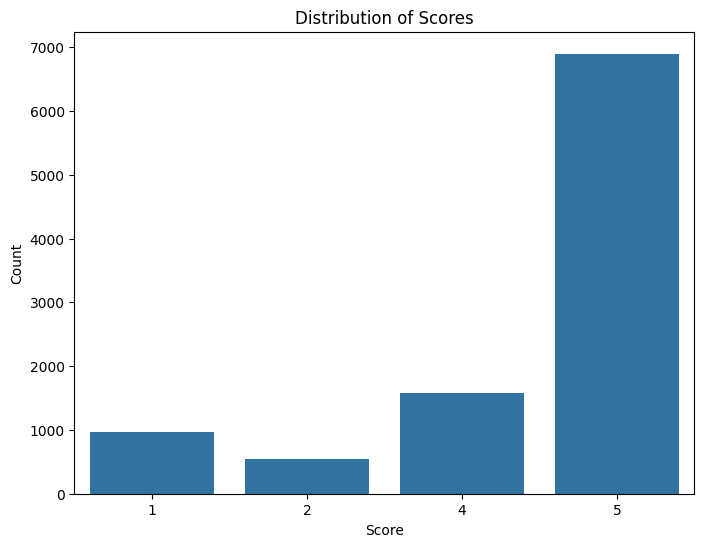

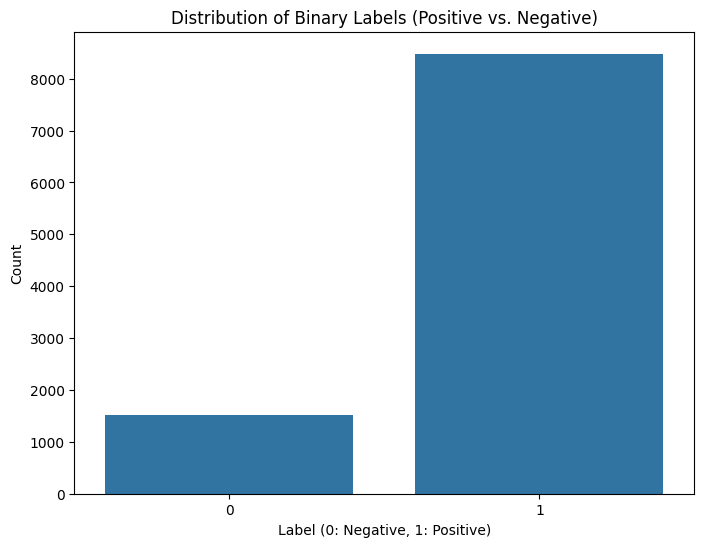

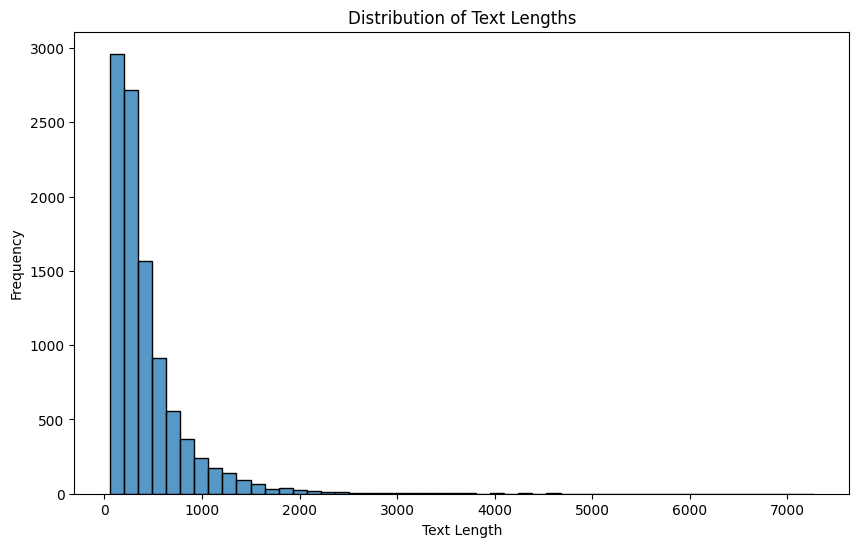

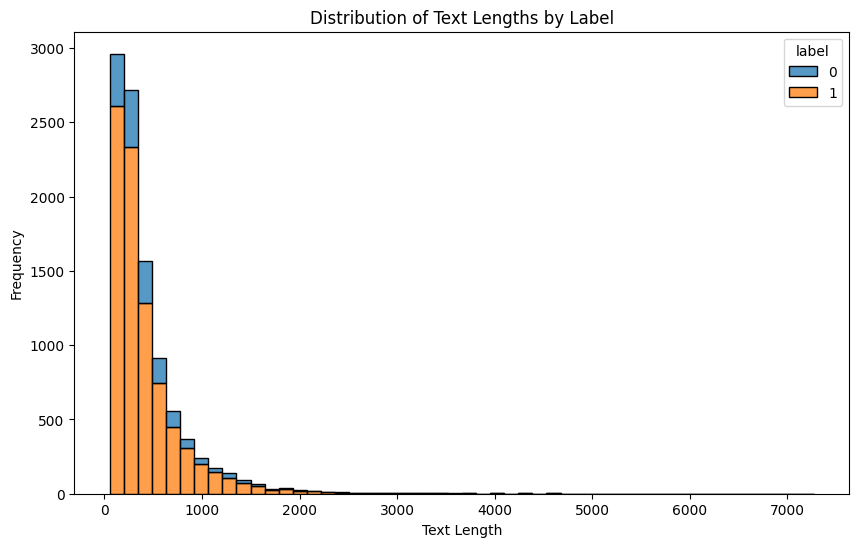

In [3]:
import matplotlib.pyplot as plt
# Check the distribution of scores
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Score')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Check the distribution of the new binary label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Binary Labels (Positive vs. Negative)')
plt.xlabel('Label (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Distribution of review length
df['text_length'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Distribution of text length by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, multiple="stack")
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
df.shape

(10000, 4)

In [5]:
lemmatizer =  WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
  text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
  text = text.split()
  tokens = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
  return ' '.join(tokens)

df['cleaned_text'] = df['Text'].astype(str).apply(clean_text)

In [6]:
df.cleaned_text.head(5)

,cleaned_text
144834,price good guess know gave 1 star low carbs an...
35623,son 4 year old eating plasmon cooky since birt...
177741,good stuff wish would run special though liked...
58029,two cavalier constantly scratching decided try...
58458,daughter love product often purchase local spe...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 5000)
x_tfidf = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_tfidf,  y, test_size = 0.2 , random_state = 42)

In [9]:
model = Sequential()
model.add(Dense(128, input_shape=(x_train.shape[1],), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

# Step 5: Train the model
start_train = time.time()
history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_split=0.1)
end_train = time.time()

# Step 6: Evaluate
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy:", accuracy)
print("Training Time:", end_train - start_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8426 - loss: 0.5430 - val_accuracy: 0.8550 - val_loss: 0.3437
Epoch 2/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8509 - loss: 0.2990 - val_accuracy: 0.8863 - val_loss: 0.2607
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8751 - loss: 0.2555
Accuracy: 0.8665000200271606
Training Time: 7.233719348907471


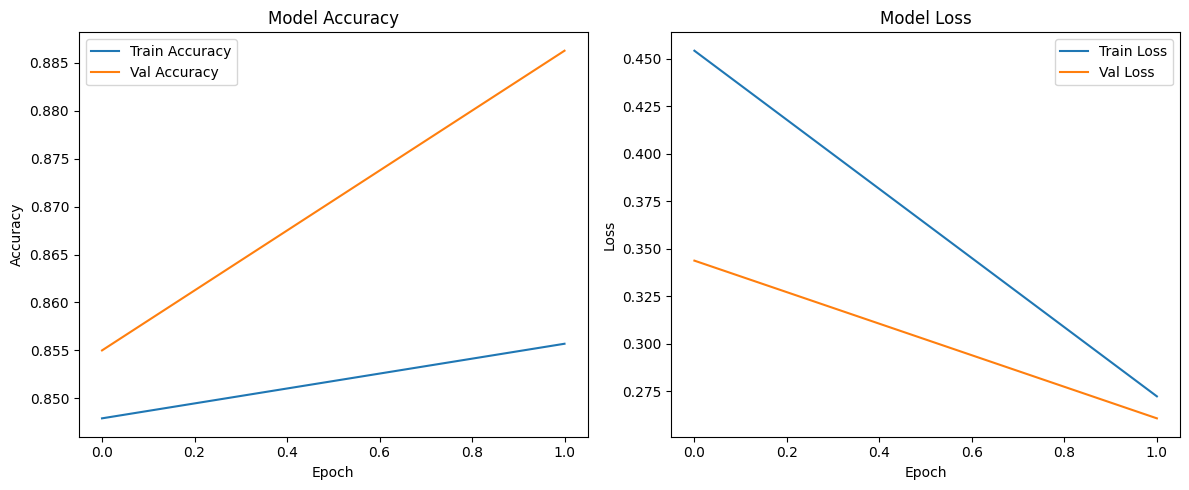

In [10]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.19      0.31       323
           1       0.86      1.00      0.93      1677

    accuracy                           0.87      2000
   macro avg       0.90      0.59      0.62      2000
weighted avg       0.88      0.87      0.83      2000



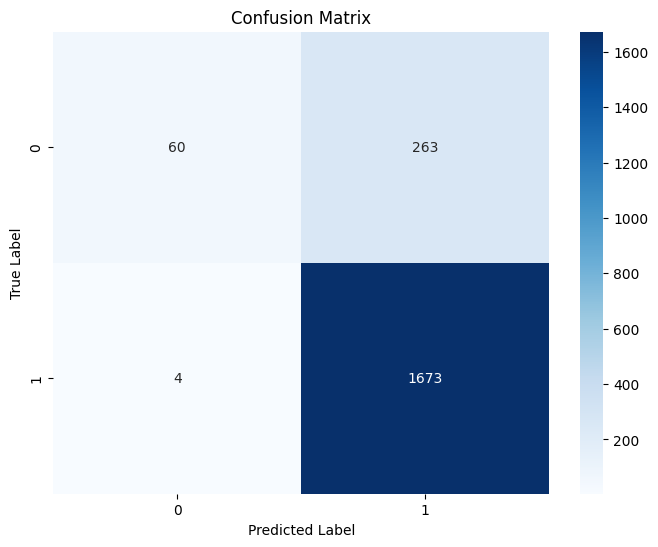

In [13]:
# precision, recall, F1-score, confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Generate predictions
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()